# Moscow housing prediction

By Hauk Aleksander Olaussen, Charbel Badr and Noran Baskaran

## About the group

TODO

## Introduction

For this project we were tasked to create a machine learning algorithm that could predict house prices in Moscow based on a set of houring features and known prices for the given house or apartment.
This notebook will give insight into how we explored the data to find out if any of the data was related to each other, and vice versa. It will show how we altered and formed the given dataset into something our machine learning model would understand better by removing features that does not have as much influence on the price, and adding features that did. This way, we managed to improve the score of the algorithm by engineering the data to our advantage.

Through the notebook, we will give examples in text, code and images (graphs) to give a complete discussion, allowing you to follow our thought process all the way from initial thoughts to finished model.

We will seperate the notebook into sections, making it easy to follow:
* **Data exploration and cleaning**
* **Feature engineering**
* **Trying different models**
* **Tuning hyperparameters**
* **Analyzing the error**
* More coming...


The following code will allow us to auto reload code when changes are made.

In [1]:
%load_ext autoreload

We begin with importing external and self made modules. Below you can see a description of the modules used:

- `numpy` is the defacto python package for numerical calculation. Most other numerical libraries (including pandas) is based on numpy.
- `pandas` is a widely used package for manipulating (mostly) tabular data
- `matplotlib` is the most used plotting library for python
- `seaborn` contains several convience functions for matplotlib and integrates very well with pandas
- `train_test_split` used for splitting training data into actual training and validation data
- `Visualizer` contains several functions used to plot different parts of the data and their correlation
- `Preprocessor` contains the main bulk of code used to preprocess and feature engineer the data provided to transform the data into something more understandable to a model
- `Model` contiains the model used for predicting the price of an apartment or house based on the data preprocessed by Preprocessor


In [117]:
%autoreload
 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from Visualizer import Visualizer
from Preprocessor import Preprocessor
from Model import Model
from TestModel import TestModel

sns.set_style('darkgrid')
pd.set_option("display.max_columns", None)

## Data exploration and cleaning

In this section we want to get a good look at the data. We want to find out what datatypes we must work with, how the structure looks like, and if we have any *NaN* values we need to work around.
The dataset is split into two different files - namely **buildings** and **apartments**. Apartments have a field which points to a building, connecting the two. This is something we will have to look at later in the process, as a building has a lot to say about the standards of the apartment. 

Below you can see the head entries for both the *apartments* and *buildings*.

### Apartments

#### Training data

In [3]:
preprocessor = Preprocessor()
apartments = preprocessor.apartments
apartments.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,0.0,2.0,0.0,1.0,NaN,NaN,NaN,1.0,4076
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,2.0,0.0,1.0,1.0,1.0,0.0,3.0,1.0,1893
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,0.0,2.0,1.0,1.0,NaN,NaN,NaN,1.0,5176
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,0.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0,1893
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,1.0,0.0,1.0,1.0,0.0,1.0,3.0,1.0,6604


#### Test data

In [4]:
apartments_test = preprocessor.apartments_test
apartments_test.head()

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,1.0,'5148'
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,NaN,1.0,0.0,NaN,NaN,3.0,1.0,1290
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,0.0,1.0,0.0,NaN,NaN,NaN,1.0,681
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,4261
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,7530


### Buildings

#### Training data

In [5]:
buildings = preprocessor.buildings
buildings.head()

,id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,264,0.0,55.518117,37.355139,11.0,улица 1-я Нововатутинская,3,2019.0,2.0,12.0,1.0,1.0,1.0,0.0,1.0,3.0
1,6079,0.0,55.641920,37.352156,7.0,мкр. 10-й,к1014,1981.0,3.0,22.0,0.0,1.0,1.0,NaN,1.0,0.0
2,5829,0.0,55.770011,37.386220,7.0,Рублевское шоссе,68,2002.0,3.0,24.0,0.0,1.0,1.0,NaN,NaN,0.0
3,5758,0.0,55.739934,37.426070,7.0,Рублевское шоссе,93К2,2011.0,3.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0
4,6761,0.0,55.649921,37.467994,7.0,улица Академика Анохина,58К2,2005.0,3.0,22.0,0.0,1.0,1.0,NaN,0.0,0.0


#### Test data

In [6]:
buildings_test = preprocessor.buildings_test
buildings_test.head()

,id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,6659,0.0,55.802771,37.510709,1.0,улица Алабяна,3К3,1962.0,0.0,8.0,0.0,1.0,0.0,NaN,1.0,0.0
1,369,1.0,55.511730,37.351958,11.0,Кленовые Аллеи ЖК,к2,2020.0,NaN,15.0,0.0,1.0,1.0,1.0,NaN,NaN
2,5658,0.0,55.865763,37.541790,1.0,Коровинское шоссе,3К1,1967.0,3.0,9.0,0.0,1.0,0.0,NaN,1.0,0.0
3,5903,0.0,55.848640,37.516745,1.0,3-й Лихачевский переулок,5,1985.0,3.0,14.0,0.0,1.0,1.0,NaN,1.0,0.0
4,7782,1.0,55.499290,37.521309,11.0,Остафьево ЖК,к6,2020.0,2.0,13.0,1.0,1.0,1.0,1.0,0.0,NaN


**Great!**
This gives us some initial insight on how the data looks. We see that we have a lot of different features here. Some of them will probably not influence the price at all (or at least to a very low degree), and some may influence the price a great deal. The data has a combination of numerical, ordinal and categorical features, which is good. This variety opens a lot of doors for us when we are to explore and engineer the data later.

We can also see that we have a lot of *NaN* values in the data - which is something we will have to deal with.

First, let us combine the **apartments** and **buildings** based in the *bulding_id* field to get a better look.

### Merging apartments and buldings

#### Training data

In [7]:
merged = preprocessor.merged.copy()
merged.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,0.0,2.0,0.0,1.0,NaN,NaN,NaN,1.0,4076,1.0,55.544046,37.478055,11.0,Бунинские Луга ЖК,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,2.0,0.0,1.0,1.0,1.0,0.0,3.0,1.0,1893,0.0,55.861282,37.666647,2.0,улица Радужная,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,0.0,2.0,1.0,1.0,NaN,NaN,NaN,1.0,5176,1.0,55.663299,37.515335,6.0,Саларьево Парк ЖК,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,0.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0,1893,0.0,55.861282,37.666647,2.0,улица Радужная,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,1.0,0.0,1.0,1.0,0.0,1.0,3.0,1.0,6604,0.0,55.590785,37.451438,11.0,улица Сервантеса,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


#### Test data

In [8]:
merged_test = preprocessor.merged_test.copy()
merged_test.head()

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,1.0,5148,0.0,55.762247,37.549040,0.0,2-я Черногрязская улица,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,NaN,1.0,0.0,NaN,NaN,3.0,1.0,1290,0.0,55.591467,37.452651,11.0,улица Сервантеса,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,0.0,1.0,0.0,NaN,NaN,NaN,1.0,681,1.0,55.617017,37.413718,11.0,Саларьево Парк ЖК,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,4261,0.0,55.569052,37.479510,11.0,улица Александры Монаховой,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,7530,0.0,55.518041,37.343829,11.0,улица 3-я Нововатутинская,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0


### Merging the training and test sets into one
We will now merge these dataframes into one. We do this so we can be sure that the preprocessing is uniform across both the training, and test set. One important thing to remember is that the test set does not have a *price* feature, as this is the whole task. Because of this, we will need to remember where the training data stops, and the test data starts. This happens as index ***23284***


In [9]:
labels = merged["price"]
merged_final = pd.concat([merged, merged_test], ignore_index=True)
print(f"The dataframe now has {len(merged_final)} entries")

The dataframe now has 33222 entries


### Finding the NaNs
Lets see how many *NaN* values we are dealing with for each feature in the newly created combined dataframe.

In [10]:
visualizer = Visualizer()
visualizer.list_missing(merged_final.copy())

Total length: 33222
id: Amount: 0 | 0.0%
seller: Amount: 12772 | 38.44%
price: Amount: 9937 | 29.91%
area_total: Amount: 0 | 0.0%
area_kitchen: Amount: 6954 | 20.93%
area_living: Amount: 5901 | 17.76%
floor: Amount: 0 | 0.0%
rooms: Amount: 0 | 0.0%
layout: Amount: 25010 | 75.28%
ceiling: Amount: 16111 | 48.49%
bathrooms_shared: Amount: 5589 | 16.82%
bathrooms_private: Amount: 5589 | 16.82%
windows_court: Amount: 11560 | 34.8%
windows_street: Amount: 11560 | 34.8%
balconies: Amount: 15355 | 46.22%
loggias: Amount: 15355 | 46.22%
condition: Amount: 13769 | 41.45%
phones: Amount: 120 | 0.36%
building_id: Amount: 0 | 0.0%
new: Amount: 373 | 1.12%
latitude: Amount: 2 | 0.01%
longitude: Amount: 2 | 0.01%
district: Amount: 155 | 0.47%
street: Amount: 0 | 0.0%
address: Amount: 0 | 0.0%
constructed: Amount: 1168 | 3.52%
material: Amount: 5643 | 16.99%
stories: Amount: 0 | 0.0%
elevator_without: Amount: 537 | 1.62%
elevator_passenger: Amount: 537 | 1.62%
elevator_service: Amount: 537 | 1.62%
par

We see that the majority of the features has some *NaN* values. Some of them, like *layout* has a lot - **25k** out of **33**. <br>
Multiple fields have over 40% *NaNs*.

Also, notice that price has 9937 *NaN* values, as we have combined the dataframes.

### Initial removing and filling of features
We will remove features with an overwhelming amount of *NaN* values (over 40% in both training and test data), as these will just cause noise in the model, and features consisting of strings (such as the street and address), which will be impossible to categorize. We will also remove the *elevator_without* feature, as the two other elevator feature will tell us what this boolean value should be. All this is done by the `Preprocessor.general_removal()` funciton.

We will also do a general clean-up of the *NaN* values. We do this with the `Preprocessor.remove_NaNs()` function. It will fill in data for all *NaN* values. For continuous values we we do this by calculating some sort of average or mean for each district in a combined set of both training and test data. For categorical values, this is mostly done by using the most used value - or *mode*. Apartments without a district will use the closest neighboors district.

In [11]:
general_removed = preprocessor.general_removal(merged_final.copy())
data = preprocessor.remove_NaNs(general_removed.copy())
visualizer.list_missing(data)

Total length: 33222
id: Amount: 0 | 0.0%
seller: Amount: 0 | 0.0%
price: Amount: 9937 | 29.91%
area_total: Amount: 0 | 0.0%
area_kitchen: Amount: 0 | 0.0%
area_living: Amount: 0 | 0.0%
floor: Amount: 0 | 0.0%
rooms: Amount: 0 | 0.0%
bathrooms_shared: Amount: 0 | 0.0%
bathrooms_private: Amount: 0 | 0.0%
windows_court: Amount: 0 | 0.0%
windows_street: Amount: 0 | 0.0%
phones: Amount: 0 | 0.0%
building_id: Amount: 0 | 0.0%
new: Amount: 0 | 0.0%
latitude: Amount: 0 | 0.0%
longitude: Amount: 0 | 0.0%
district: Amount: 0 | 0.0%
constructed: Amount: 0 | 0.0%
material: Amount: 0 | 0.0%
stories: Amount: 0 | 0.0%
elevator_passenger: Amount: 0 | 0.0%
elevator_service: Amount: 0 | 0.0%
parking: Amount: 0 | 0.0%
garbage_chute: Amount: 0 | 0.0%
heating: Amount: 0 | 0.0%


This proves we have removed all the *NaN* values in the dataset except price, which makes sense.<br>
The head now looks like this

In [12]:
data.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,0.0,2.0,0.0,1.0,1.0,4076,1.0,55.544046,37.478055,11.0,2021.0,3.0,9.0,1.0,1.0,1.0,1.0,0.0
1,1,3.0,10500000.0,88.0,14.2,48.0,18.0,3.0,2.0,0.0,1.0,1.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,1.0,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,0.0,2.0,1.0,1.0,1.0,5176,1.0,55.663299,37.515335,6.0,2021.0,3.0,15.0,1.0,1.0,1.0,1.0,0.0
3,3,3.0,10500000.0,88.0,14.0,48.0,18.0,3.0,0.0,2.0,1.0,1.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,1.0,0.0
4,4,3.0,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,0.0,1.0,1.0,1.0,6604,0.0,55.590785,37.451438,11.0,2017.0,2.0,15.0,1.0,1.0,1.0,0.0,0.0


### Visualizing the distribution of features
Below, you can see graphs for all the features in the merged dataframe. It gives some insight into how the data is distributed across the dataset.

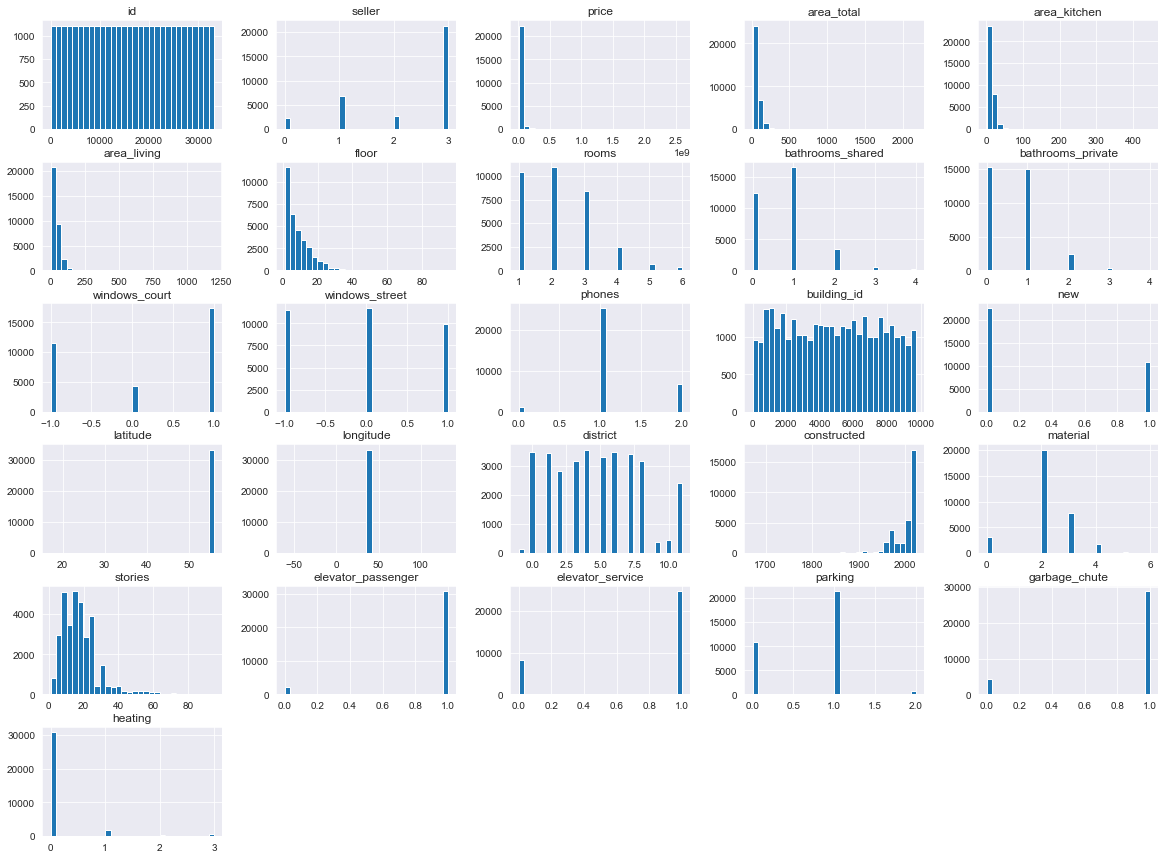

In [13]:
data.hist(bins=30, figsize=(20,15))
plt.show()

What we are looking for here are data with odd distributions. We can see that some of these diagrams are heavily "one sided". What we mean by this is that some of the data has mostly one value, or is skewed in some way. We can remove this by taking the logarithm of the given variables. We start doing this in the feature engineering part

### Visualizing correlations

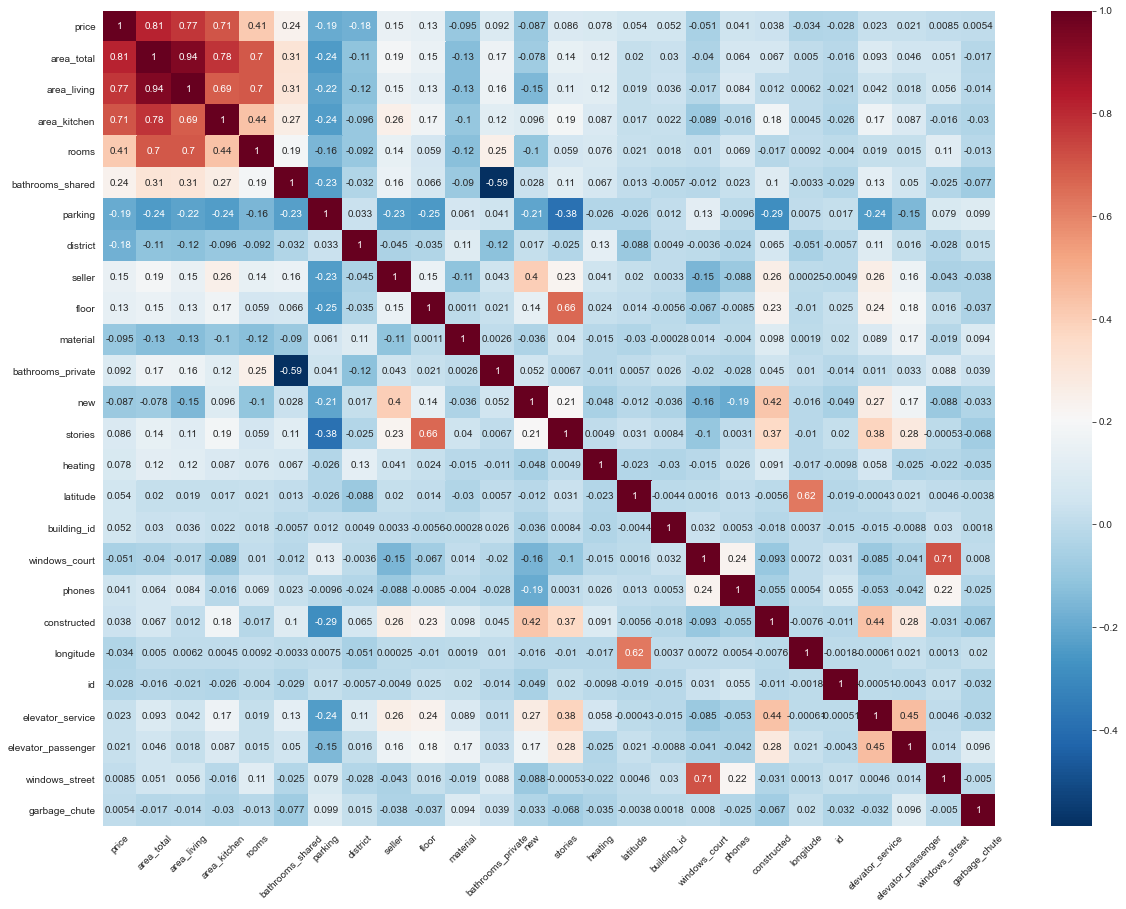

In [14]:
visualizer.price_correlation(data)

**Whoa!**<br>
That was quite a grid.
We can however remove some more features just by looking at this grid. There are some features with next to none correlation with the price, and some with a very high correlation.

Below is a summary of the correlations we can see between the data that have made it through the cleaning so far.. <br>
Some takeouts:
- Total area, living area, kitchen area and price are very correlated
- Amount of rooms and price are highly correlated
- Parking and price are somewhat correlated
- Amount of stories in the building and apartment floor are highly correlated
- Bathrooms private and bathrooms shared are very negatively correlated
- New and seller are somewhat correlated
- Windows street and windows court are very negatively correlated
- District and latitude/longitude are very correlated
- Constructed and the elevator features are highly correlated

## More exploration and some feature altering

Lets continue the exploration by plotting some of the distrubutions of the features with the highest correlation to price.<br>
We start with the price itself.

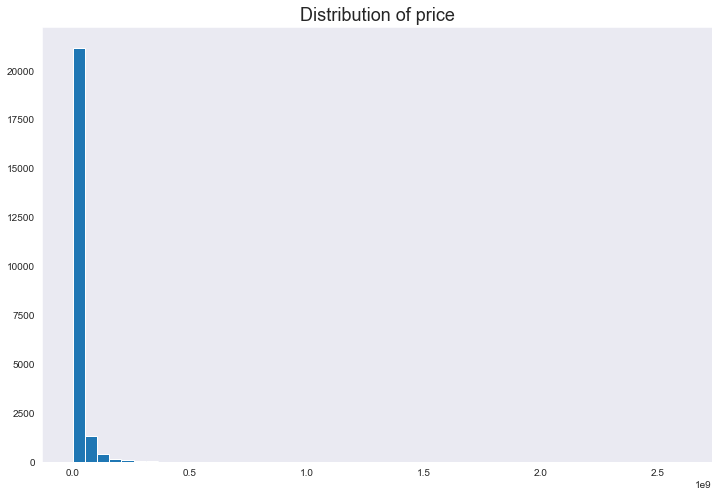

In [15]:
visualizer.plot_distribution(data, "price")

As we mentioned earlier, we can see that this value is heavily skewed. By taking the logarithm of the price, we get a much more spread out target for the algorithm. This will help it pinpointing more accurately where it want the price prediction to be. All we have to to is to convert it back to an actual price value. You can see the logified plot below.

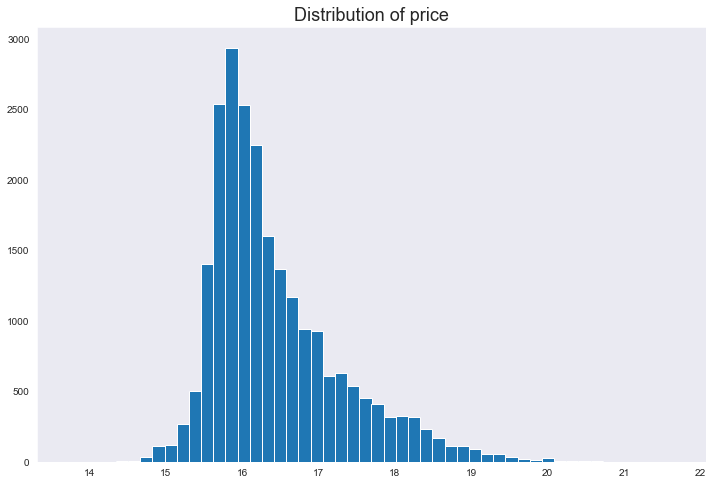

In [16]:
data = preprocessor.logify(data.copy(), "price")
visualizer.plot_distribution(data, "price")

Now we look at the total area. 

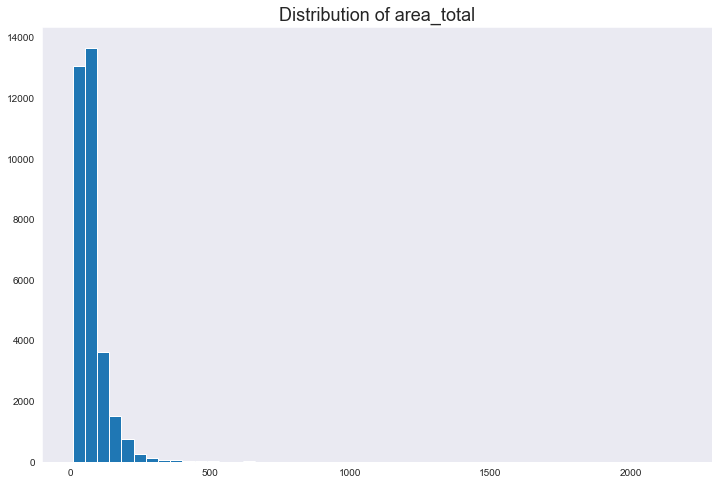

In [17]:
visualizer.plot_distribution(data, "area_total")

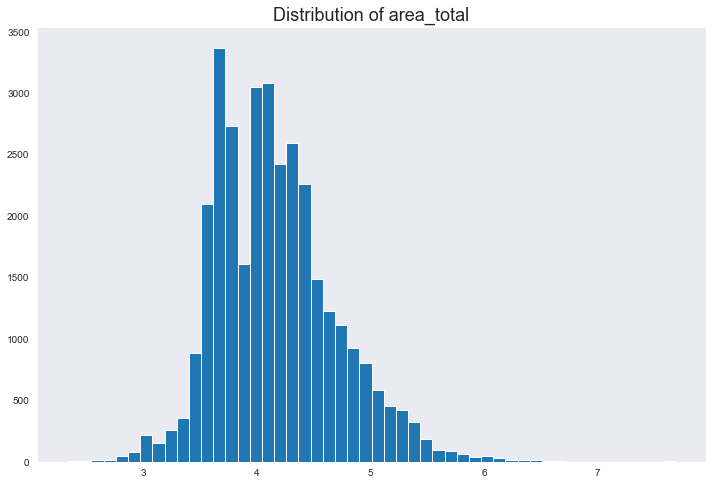

In [18]:
data = preprocessor.logify(data.copy(), "area_total")
visualizer.plot_distribution(data, "area_total")

When taking the logarithm of the total area we get this distribution. This is the feature with the highest correlation to price - which of course is not surprising. It is, however, also highly correlated so some other features, namely living area, kitchen area and the amount of rooms. One way of dealing with this could be to create a new feature with these combined in some way, or by splitting them even further. We will look into this in the feature engineering part of the notebook.

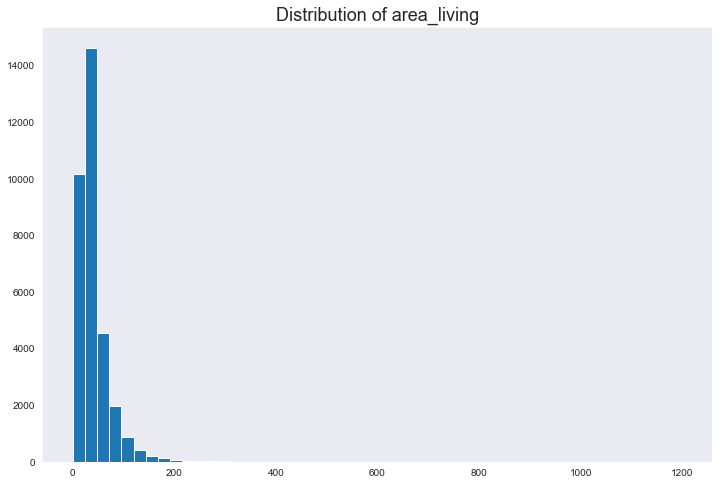

In [19]:
visualizer.plot_distribution(data, "area_living")

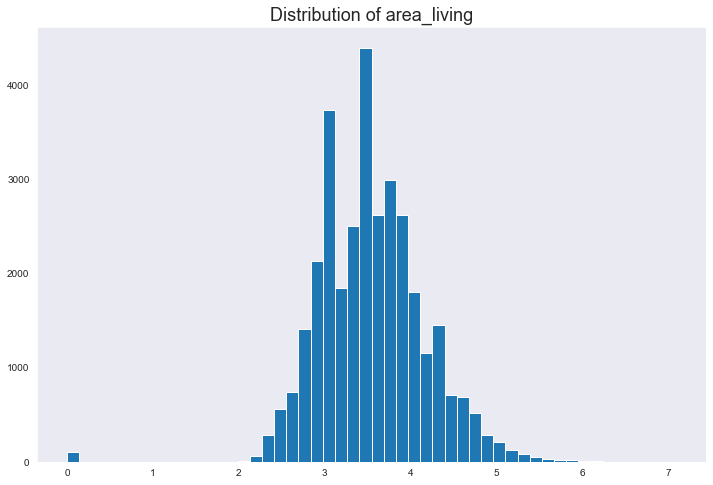

In [20]:
data = preprocessor.logify(data.copy(), "area_living")
visualizer.plot_distribution(data, "area_living")

This shows something worth fixing. The living area will never be 0. This is just as worthless as it being *NaN*. Because of this, we fix it so that the 0 values use the average from their district. The new distribution looks like this:

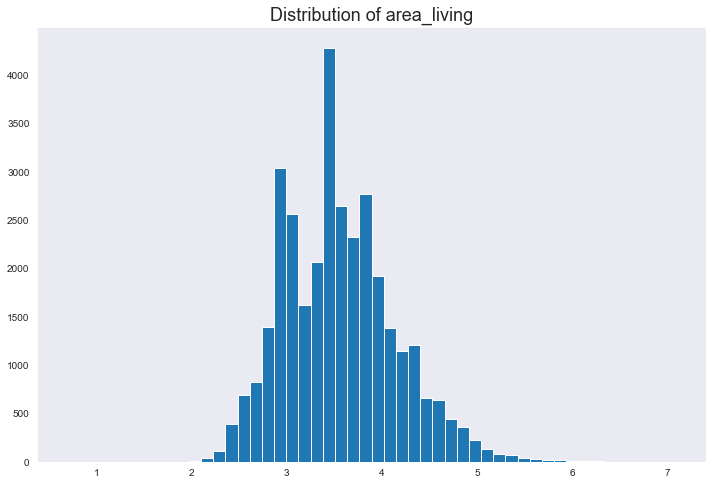

In [21]:
data = preprocessor.remove_zero_values(data.copy(), "area_living")
visualizer.plot_distribution(data, "area_living")

Because this phenomenon was present in the *area_living* feature, we check the *area_kitchen* feature as well.

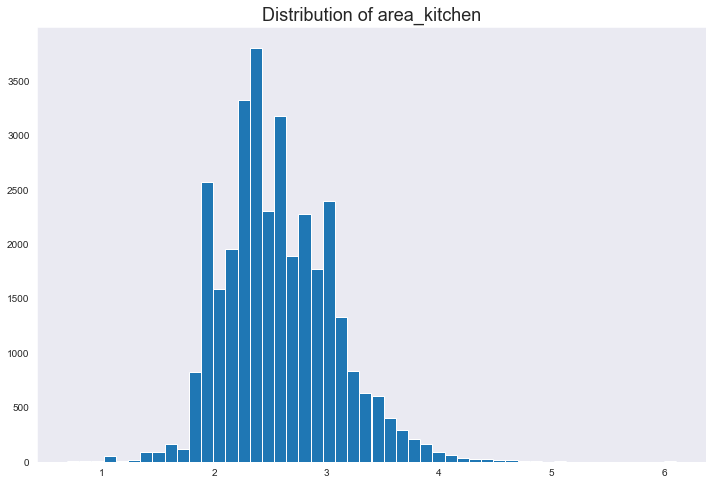

In [22]:
data = preprocessor.logify(data.copy(), "area_kitchen")
visualizer.plot_distribution(data, "area_kitchen")

Luckily, this problem was not present in this column. Still, as the feature was very skewed (as previuosly mentioned), we keep it logified.

## Scattering some correlations

The correlation grid above gives us good insight in how the features are correlated to each other, but is of course not everything we need. In this section we will plot different features against each other to visualize the correlations between them. This may lead to us finding features we want to combine, but may also lead to us finding that we do not need a spesific feature. We will see.

Visualizing the correlations between different features will give us futher insight in how we will transform and change the data in later sections. For plotting with the price, we will use just the training data part of the dataframe, as the test part does not have this feature

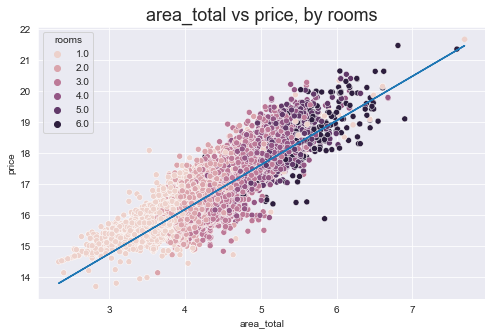

In [23]:
data_with_price = data[:23285].copy()
visualizer.plot_vs(data_with_price, "area_total", "price", reg=True, figsize=(8,5), hue="rooms")

Using rooms as the hue here shows that the more expensive apartments, which are often the largest, also have the most rooms. This shows a clear correlation between total area and the amount of rooms, which we already knew. However, the separation here are quite clear, making it even more obvious that these two depend on each other.

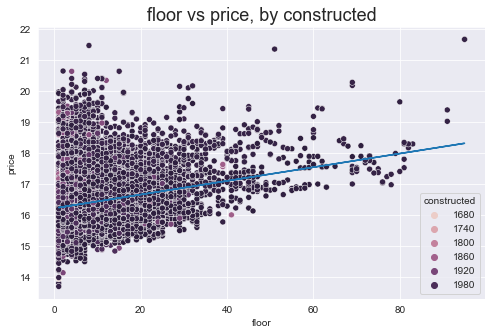

In [24]:
visualizer.plot_vs(data_with_price, "floor", "price", reg=True, figsize=(8,5), hue="constructed")

This shows something interesting. For one it shows that often, the higher the floor, the higher the price. But it also shows that the vast majority of the apartments are build in the 2010s, and they are everywhere on the plot. Meaning that the year of construction might not have as much to say when it comes to price than one might think. Lets plot this.

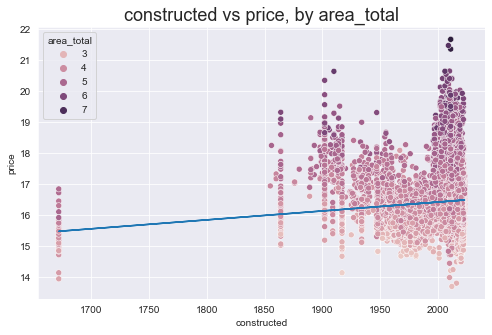

In [25]:
visualizer.plot_vs(data_with_price, "constructed", "price", reg=True, figsize=(8,5), hue="area_total")

Look at that. The price based on contruction year is very scattered around. It look like the construction year does not really matter as much as one might think when it comes to price. You can clearly see "average" vertial lines where we have imputed the valies, but still - it shows that it does not have that much to say for the price of the apartment. We have set the hue to show the total area in this case, showing that even though some of the old buildings are large, they are not that much bigger than apartments in the same price range built many years later. This is fascinating. 

We did not plot all features here, but just a select few, just to show that some of these features are very scattered. This means that even though some correlation does exist, it will be quite hard to know where to place the price for a new apartment based on the training data. 

Before starting the feature engineering, lets plot some of the features against each other, and not only the price. This will give us some insight in how the features are correlated to each other, and not only the price. Maybe we can find a way to create new and better features out of this exploration, like we did with latitude and longitude earlier? Lets see.

#### Exploring features correlated to eachother

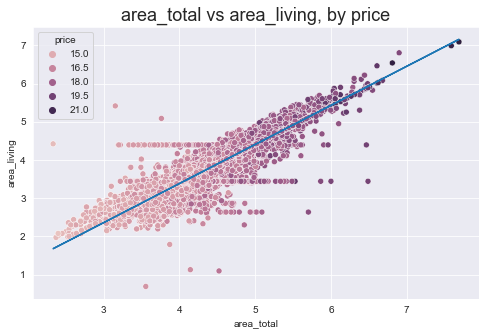

In [26]:
visualizer.plot_vs(data, "area_total", "area_living", reg=True, figsize=(8,5), hue="price")

As we though, total area, living area and rooms are very correlated. The price of the apartment also follows this trend it seems. We will look at this correlation when we start feature engineering as these might be eligible for altering and/or combining.

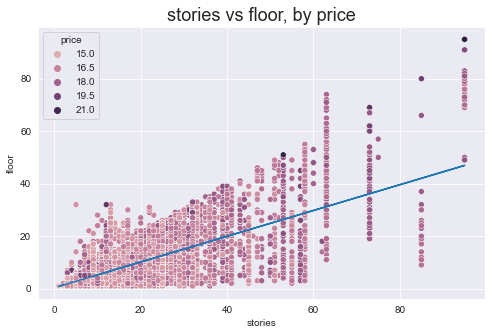

In [27]:
visualizer.plot_vs(data, "stories", "floor", reg=True, figsize=(8,5), hue="price")

This plot shows a clear correlation with stories and floor. Of course, it is not very surprising that apartments on higher floors are in buildings with more stories. The hue here is based on the price, showing some lean towards higher story buldings, and apartments on the higher floors of them. Maybe something to think about 

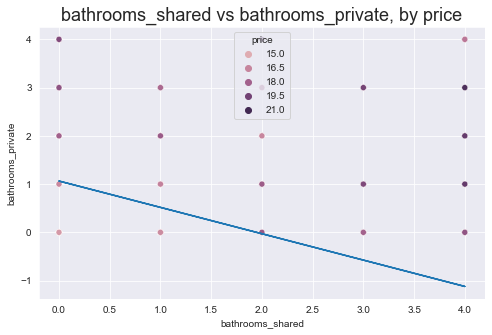

In [28]:
visualizer.plot_vs(data, "bathrooms_shared", "bathrooms_private", reg=True, figsize=(8,5), hue="price")

Nothing very surprising here. When the amount of private bathrooms goes down, the amount of shared bathrooms go up, and vice versa.

Lets look at the latitude and longitude. These are features we will combine later to find the distance to different things around town. They should be pretty similar, as we are located inside the same city.

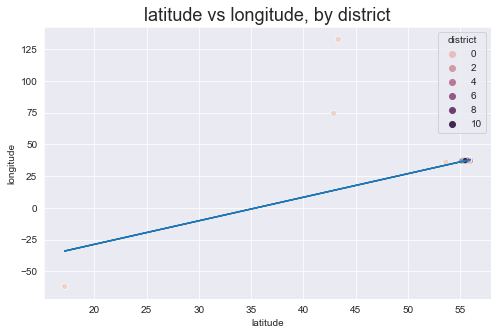

In [29]:
visualizer.plot_vs(data, "latitude", "longitude", reg=True, figsize=(8,5), hue="district")

Now this is weird. We can see almost all the apartments are clumped together around *latitude* = 55 and *longitude* = 35 (roughly), but there are some apartments not even close to the rest. Lets try finding these apartments, and how many they are:

In [30]:
is_outlier = (data["longitude"] > 55) | (data["latitude"] < 54)
outliers = data.copy()[is_outlier]
outliers

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating
23308,23308,3.0,NaN,3.688879,2.484907,2.772589,6.0,1.0,1.0,0.0,1.0,0.0,1.0,3803,1.0,53.651999,36.264789,-1.0,2019.0,2.0,12.0,1.0,1.0,1.0,1.0,0.0
23375,23375,1.0,NaN,3.754199,2.468100,3.010621,13.0,1.0,1.0,0.0,0.0,1.0,2.0,3803,1.0,53.651999,36.264789,-1.0,2019.0,2.0,12.0,1.0,1.0,1.0,1.0,0.0
25796,25796,3.0,NaN,3.034953,1.808289,2.341806,11.0,1.0,0.0,1.0,-1.0,-1.0,1.0,4636,1.0,17.141734,-61.790500,-1.0,2021.0,3.0,17.0,0.0,0.0,1.0,0.0,0.0
25814,25814,2.0,NaN,3.443618,1.975430,2.870662,1.0,1.0,0.0,1.0,-1.0,-1.0,0.0,4202,0.0,42.914700,74.517184,-1.0,2016.0,2.0,3.0,1.0,1.0,1.0,1.0,0.0
28004,28004,2.0,NaN,5.123964,2.944439,4.836282,5.0,4.0,1.0,2.0,1.0,1.0,1.0,8811,0.0,43.353545,132.768097,-1.0,2007.0,2.0,5.0,1.0,1.0,1.0,1.0,0.0
28375,28375,0.0,NaN,3.797734,1.791759,3.394508,4.0,2.0,0.0,1.0,-1.0,-1.0,0.0,4412,1.0,17.141734,-61.790500,-1.0,2021.0,2.0,9.0,1.0,1.0,1.0,1.0,0.0
30244,30244,3.0,NaN,3.034953,1.808289,2.341806,11.0,1.0,0.0,1.0,-1.0,-1.0,1.0,4636,1.0,17.141734,-61.790500,-1.0,2021.0,3.0,17.0,0.0,0.0,1.0,0.0,0.0
31881,31881,0.0,NaN,3.339322,1.883183,2.769168,17.0,1.0,1.0,0.0,0.0,1.0,1.0,4412,1.0,17.141734,-61.790500,-1.0,2021.0,2.0,9.0,1.0,1.0,1.0,1.0,0.0
32832,32832,3.0,NaN,5.247024,3.682204,4.652514,1.0,5.0,0.0,1.0,-1.0,-1.0,1.0,5667,0.0,43.352968,132.759204,-1.0,1994.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0


This shows 8 outliers in the dataset. As all of them have *NaN* price, we know that these are from the testset. We can verify this by looking at the *id* field, which tells us that all of the outliers have ids larger than ***23284***. As these are not in the training set, we cannot remove them - because we need to predict prices for them. We will assume that this building is misrepresented in the test data, and will give these apartments the average latitude and longitude in district 4. We do this with the function `Preprocessor.fix_latlon_outliers()`.

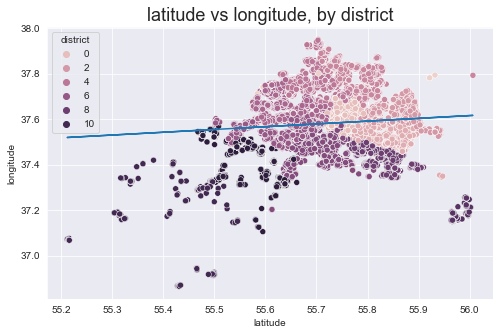

In [31]:
removed_outliers = preprocessor.fix_latlon_outliers(data.copy(), outliers)
visualizer.plot_vs(removed_outliers, "latitude", "longitude", reg=True, figsize=(8,5), hue="district")

**This is better!**
We can clearly see the different districts when we plot the latitude and longitude like this. We see that the apartments gather around a circular center, with the lower numbered districts being closer to center. We can look at this as a city center, which will probably be very important later. This is a fascinating plot, as two features not really correlating that much to the price, will have a big impact when combined later into one feature called *distance_center* - which will be the distance to the city center. 

### TODO - More plotting of features

## Feature engineering

This section is where we will change the data in a more drastic way than we have. We have already cleaned the data, removing NaNs and non-important features, but that does not mean that we will not find a way to combine other non-correlating features into new ones with actual impact. We will try to create features where they correlate to the price in a more impactful manner than they did alone, making it easier for the machine learning algorithm to predict accurately.

We will reference to earlier sections when discussing and explaining our though processes as the insight obtained in the data exploration phase will be used all through this section. 

Earlier in this notebook we did some minor feature engineering when we removed the skew for some features using the logarithm.

In the exploration we found correlations between the total area, living area, kitchen area and the amount of rooms in an apartment. Let's see what one or more combinations of these would look like. <br>
We will create a new features for this: **avg_room_size**, **living_fraction** and **kitchen_fraction**

- **avg_room_size**: the average size of a room in the apartment.
- **living_fraction**: *area_living* / *area_total*
- **kitchen_fraction**: *area_kitchen* / *area_total*

This is done by the function `Preprocessor.combine_area_rooms()`

                  avg_room_size  living_fraction  kitchen_fraction     price
avg_room_size          1.000000        -0.464081          0.236340 -0.450685
living_fraction       -0.464081         1.000000         -0.408683  0.299087
kitchen_fraction       0.236340        -0.408683          1.000000  0.124355
price                 -0.450685         0.299087          0.124355  1.000000


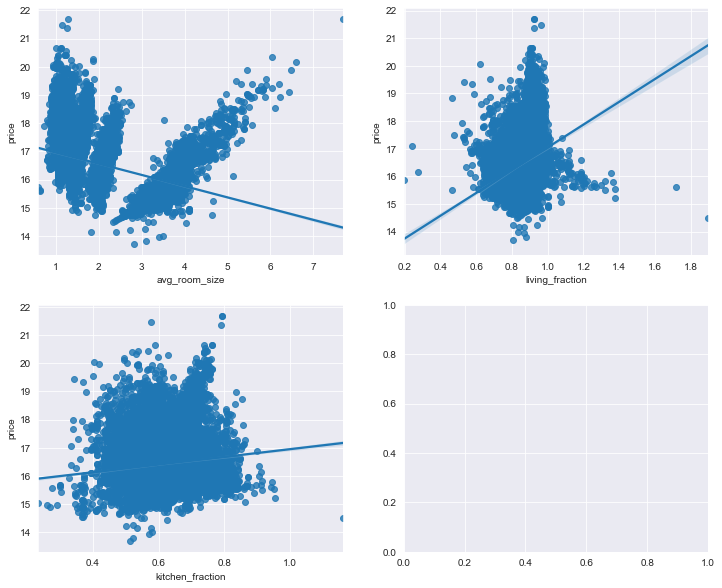

In [74]:
featured = preprocessor.combine_area_rooms(data.copy())
visualizer.corr_target(featured, cols=["avg_room_size", "living_fraction", "kitchen_fraction"], target='price')

We see that the average room size does correlate to the price pretty well, but negatively. This means that the larger the rooms are on average, the lower the price of the apartment is. This is different from the *living_fraction* and *kitchen_fraction* where it is less correlated to the price, but positively. This means that if the living area and kitchen area is larger, the price of the apartment will most likely be higher. We will now remove the features these are based on - *area_living*, *area_kitchen* and *rooms*.

In [75]:
featured = preprocessor.remove_labels(featured.copy(), ["area_living", "area_kitchen", "rooms"])
featured

,id,seller,price,area_total,floor,bathrooms_shared,bathrooms_private,windows_court,windows_street,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating,avg_room_size,living_fraction,kitchen_fraction
0,0,3.0,15.781156,4.097672,2.0,0.0,2.0,0.0,1.0,1.0,4076,1.0,55.544046,37.478055,11.0,2021.0,3.0,9.0,1.0,1.0,1.0,1.0,0.0,2.048836,0.845782,0.635163
1,1,3.0,16.166886,4.488636,18.0,2.0,0.0,1.0,1.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,1.0,0.0,1.496212,0.867038,0.606263
2,2,3.0,16.014916,4.375757,12.0,0.0,2.0,1.0,1.0,1.0,5176,1.0,55.663299,37.515335,6.0,2021.0,3.0,15.0,1.0,1.0,1.0,1.0,0.0,1.458586,0.853086,0.721475
3,3,3.0,16.166886,4.488636,18.0,0.0,2.0,1.0,1.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,1.0,0.0,1.496212,0.867038,0.603312
4,4,3.0,16.447399,4.369448,7.0,1.0,0.0,1.0,1.0,1.0,6604,0.0,55.590785,37.451438,11.0,2017.0,2.0,15.0,1.0,1.0,1.0,0.0,0.0,2.184724,0.820131,0.661496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33217,33217,3.0,NaN,4.672829,16.0,1.0,0.0,-1.0,-1.0,1.0,4252,1.0,55.789750,37.456468,8.0,2020.0,2.0,20.0,1.0,1.0,0.0,1.0,0.0,1.557610,0.867838,0.650516
33218,33218,3.0,NaN,4.418841,3.0,2.0,0.0,1.0,0.0,2.0,7380,1.0,55.751639,37.516260,7.0,2021.0,2.0,20.0,1.0,1.0,1.0,1.0,0.0,1.472947,0.866710,0.651639
33219,33219,3.0,NaN,3.918005,15.0,1.0,0.0,-1.0,-1.0,1.0,1480,1.0,55.770659,37.375234,7.0,2016.0,2.0,24.0,1.0,1.0,0.0,1.0,1.0,3.918005,0.851290,0.614412
33220,33220,3.0,NaN,3.683867,14.0,1.0,0.0,0.0,1.0,2.0,2154,0.0,55.699943,37.637183,5.0,2019.0,2.0,14.0,1.0,1.0,0.0,1.0,0.0,3.683867,0.754321,0.662985


We will also combine the bathroom features to one **bathroom_amount**, giving a more clearcut way of describing the bathroom situation

                   bathrooms_private  bathrooms_shared  bathroom_amount  \
bathrooms_private           1.000000         -0.586889         0.390924   
bathrooms_shared           -0.586889          1.000000         0.515807   
bathroom_amount             0.390924          0.515807         1.000000   
price                       0.134314          0.363446         0.553534   

                      price  
bathrooms_private  0.134314  
bathrooms_shared   0.363446  
bathroom_amount    0.553534  
price              1.000000  


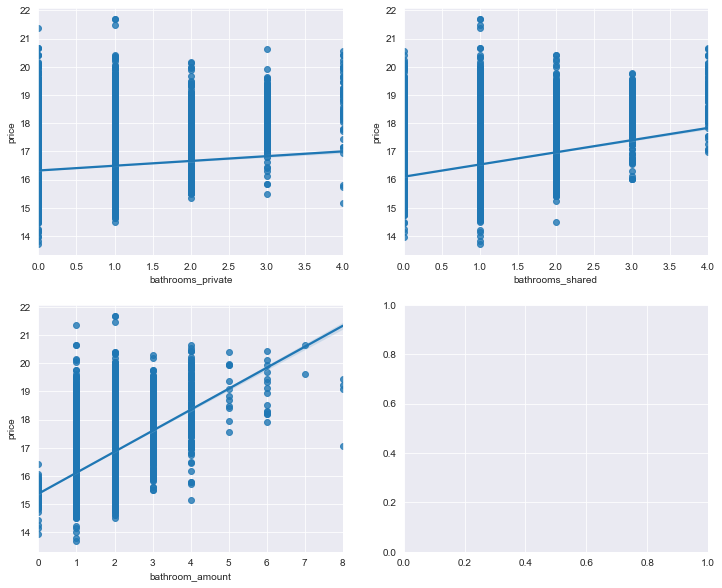

In [76]:
featured = preprocessor.combine_baths(featured.copy())
visualizer.corr_target(featured, cols=["bathrooms_private", "bathrooms_shared", "bathroom_amount"], 
                target='price')
featured = preprocessor.remove_labels(featured.copy(), labels=["bathrooms_private", "bathrooms_shared"])

This shows that combining the two gives a higher correlation to the price than each of them on their own. We will therefore remove the other two, and replace them with this new feature.

We will now turn our head to the windows - namely the *windows_street* and *windows_court* features. They do not do much like they are now, so we will try to combine these into a new categorical feature **has_windows** which describes whether or not an apartment has *none* of the two, just *one*, or *both*. We will have a seperate category for whether it is *unknown*, as a lot of *NaN* values existed in these features, and were replaced by *-1* (unknown).

                windows_street  windows_court  has_windows     price
windows_street        1.000000       0.714756     0.922860  0.042730
windows_court         0.714756       1.000000     0.921665 -0.079195
has_windows           0.922860       0.921665     1.000000  0.000852
price                 0.042730      -0.079195     0.000852  1.000000


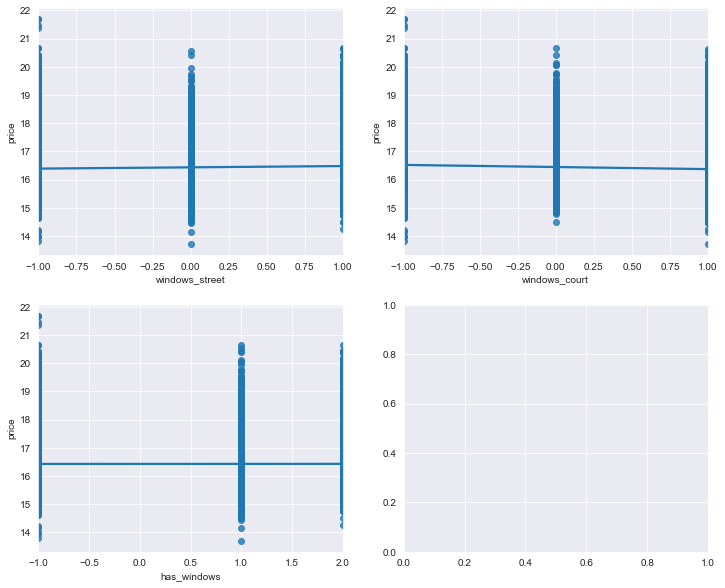

In [77]:
featured = preprocessor.combine_windows(featured.copy())
visualizer.corr_target(featured, cols=["windows_street", "windows_court", "has_windows"], target='price')

This feature does not correlate anything to the price - or at least very minimal. This is not something we want to add to our algorithm. Can we instead of making a categorical feature try to make a boolean one - describing whether or not any of the two types of windows exist? We will look at unknown as *false*.

                windows_street  windows_court  has_windows     price
windows_street        1.000000       0.714756     0.865483  0.042730
windows_court         0.714756       1.000000     0.936012 -0.079195
has_windows           0.865483       0.936012     1.000000 -0.081832
price                 0.042730      -0.079195    -0.081832  1.000000


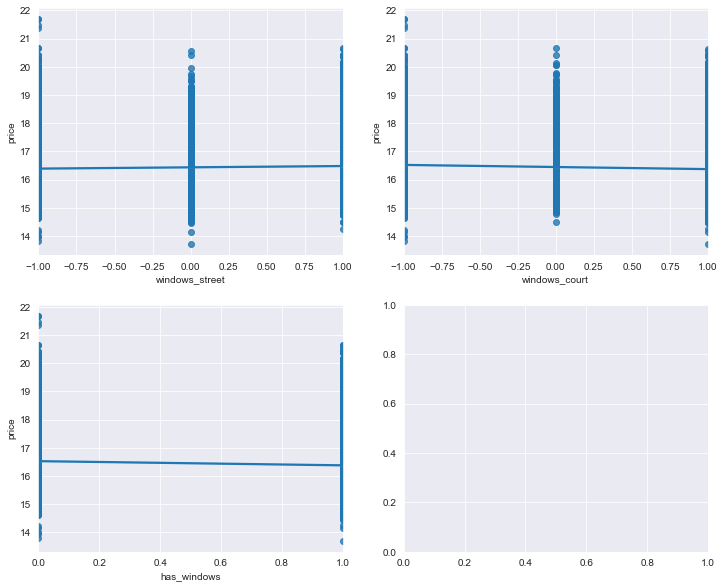

In [78]:
featured = preprocessor.combine_windows(featured.copy(), boolean=True)
visualizer.corr_target(featured, cols=["windows_street", "windows_court", "has_windows"], target='price')

This is better, but it is still a correlation of less than **0.1** to price. All these features are eligable for removal later, but we will leave them for now.

Now lets go over to one we know will have impact. We discussed this earlier when talking about *latitude* and *longitude*. We will now combine these features into a new one - **distance_center**. This will be calculated as the distance in meters to the [*red square*](https://en.wikipedia.org/wiki/Red_Square) in the very heart of Moscow. 

                 latitude  longitude  distance_center     price
latitude         1.000000   0.624006        -0.959930  0.162631
longitude        0.624006   1.000000        -0.499941 -0.067534
distance_center -0.959930  -0.499941         1.000000 -0.528687
price            0.162631  -0.067534        -0.528687  1.000000


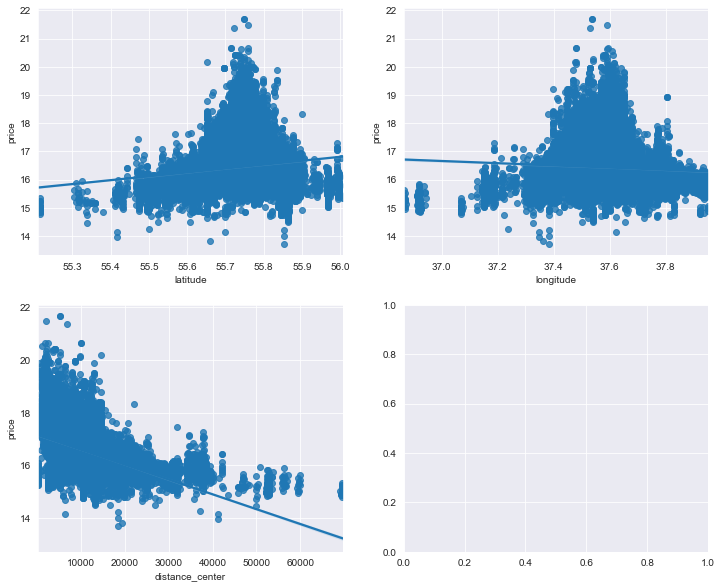

In [79]:
featured = preprocessor.combine_latlon(featured.copy())
visualizer.corr_target(featured, cols=["latitude", "longitude", "distance_center"], target='price')

As we thought. This feature has a very negative correlation to the price - meaning that when the *distance_center* feature is lower, the price gets higher. This, of course, makes sense, as apartments closer to the city center is ofter much more expensive. Lets plot this feature correlating to price.

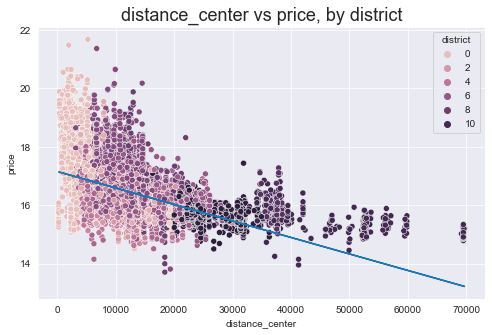

In [38]:
featured_with_price = featured[:23285].copy()
visualizer.plot_vs(featured_with_price, "distance_center", "price", reg=True, figsize=(8,5), hue="district")

The trend is very clear, and when using the district as the hue, we can clearly see how far the districts are away from the center as well - on a general basis. Lets now plot a new correlation grid to see how far we have come. First - let us remove the *id* and *building_id* fields as these are no longer needed.

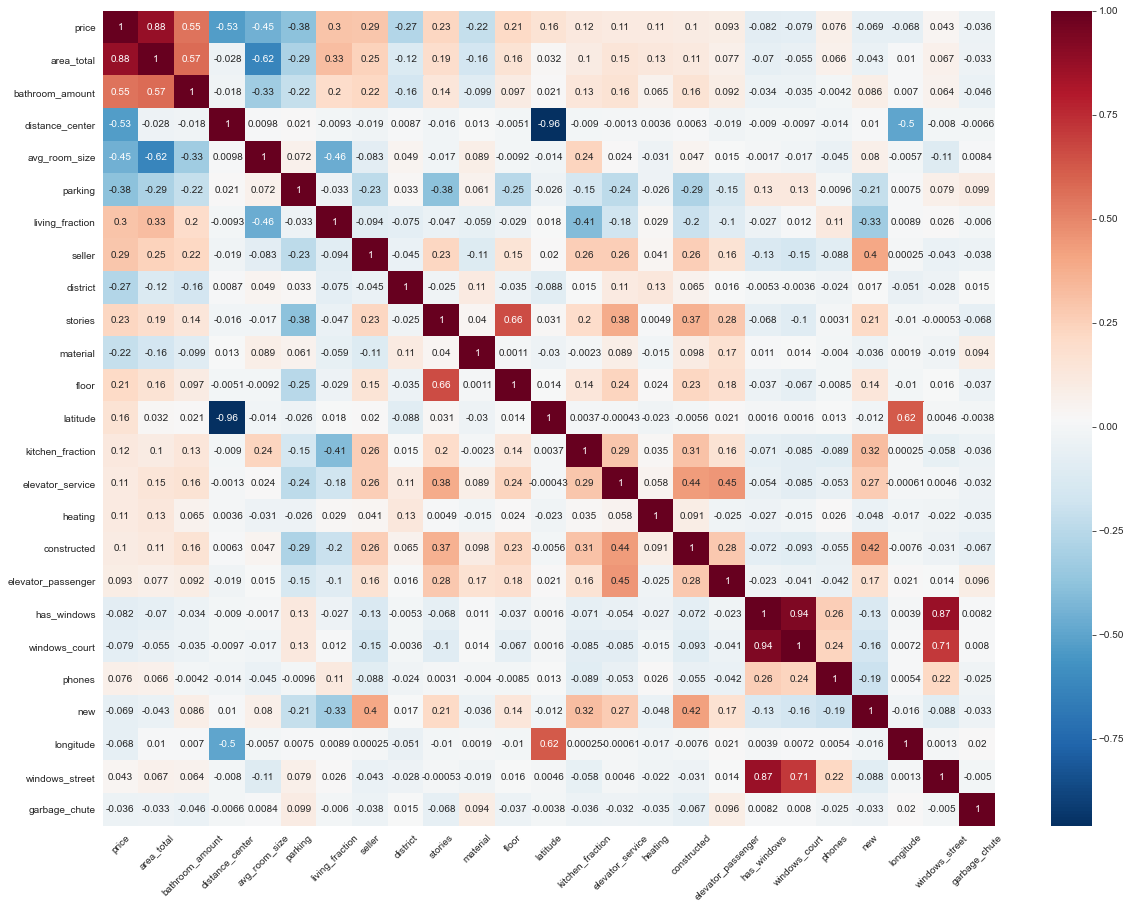

In [80]:
featured = preprocessor.remove_labels(featured.copy(), ["id", "building_id"])
visualizer.price_correlation(featured)

This has changed a lot. We have fewer features correlating to eachother, and more that correlate to price in a more impactful manner. However, there are a lot of features with below 0.1 correlation to price. We will now remove all those who does neither have a correlation higher than **0.1** to the price, or reasonable correlation to another feature. We do this because those features are not eligable for creating a new feature, nor being standalone.

We remove the features: *garbage_chute*, *phones*, *has_windows*, *windows_street* and *windows_court*

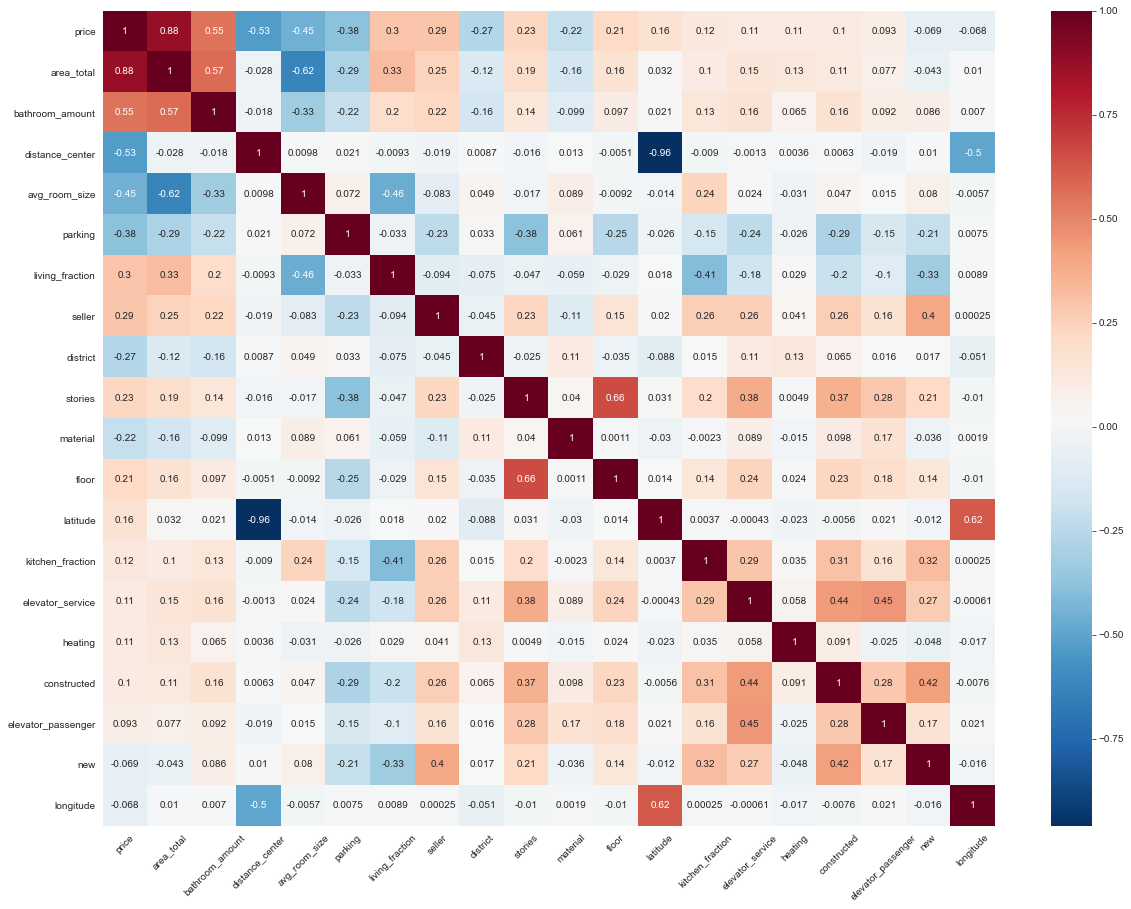

In [81]:
featured = preprocessor.remove_labels(featured.copy(), ["garbage_chute", "phones", "has_windows", "windows_street", "windows_court"])
visualizer.price_correlation(featured)

The next thing we will look at is the elevator features. We will try combine these into a *has_elevator* feature, which, much like the windows, will tell if a building has both types of elevator, just one, or none. 

                    elevator_passenger  elevator_service  has_elevator  \
elevator_passenger            1.000000          0.451153      0.759251   
elevator_service              0.451153          1.000000      0.923341   
has_elevator                  0.759251          0.923341      1.000000   
price                         0.093205          0.110322      0.120625   

                       price  
elevator_passenger  0.093205  
elevator_service    0.110322  
has_elevator        0.120625  
price               1.000000  


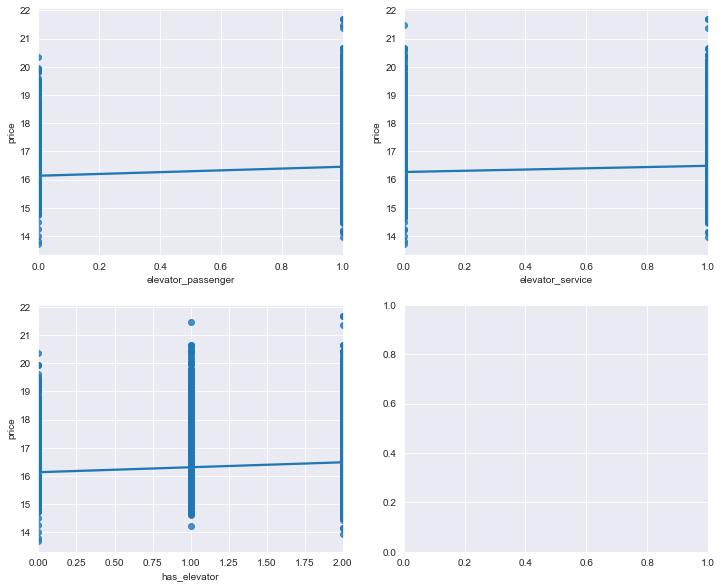

In [82]:
featured = preprocessor.combine_elevators(featured.copy())
visualizer.corr_target(featured, cols=["elevator_passenger", "elevator_service", "has_elevator"], target='price')

This feature does not really do that much, but it combines the two into a feature better than anyone of them on their own. We will remove the two other features and replace it with this, simplifying the data.

In [83]:
featured = preprocessor.remove_labels(featured.copy(), ["elevator_passenger", "elevator_service"])
featured.head()

,seller,price,area_total,floor,new,latitude,longitude,district,constructed,material,stories,parking,heating,avg_room_size,living_fraction,kitchen_fraction,bathroom_amount,distance_center,has_elevator
0,3.0,15.781156,4.097672,2.0,1.0,55.544046,37.478055,11.0,2021.0,3.0,9.0,1.0,0.0,2.048836,0.845782,0.635163,2.0,25022.080164,2
1,3.0,16.166886,4.488636,18.0,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,0.0,1.496212,0.867038,0.606263,2.0,12267.029455,2
2,3.0,16.014916,4.375757,12.0,1.0,55.663299,37.515335,6.0,2021.0,3.0,15.0,1.0,0.0,1.458586,0.853086,0.721475,2.0,12060.133853,2
3,3.0,16.166886,4.488636,18.0,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,0.0,1.496212,0.867038,0.603312,2.0,12267.029455,2
4,3.0,16.447399,4.369448,7.0,0.0,55.590785,37.451438,11.0,2017.0,2.0,15.0,1.0,0.0,2.184724,0.820131,0.661496,1.0,21041.782467,2


Now lets look at two features that should correlate a lot - namely *new* and *constructed*. There is no reason having both these in the dataset, as the year of construction should tell us if the apartment is new or not. Let plot these agains each other and have a look.

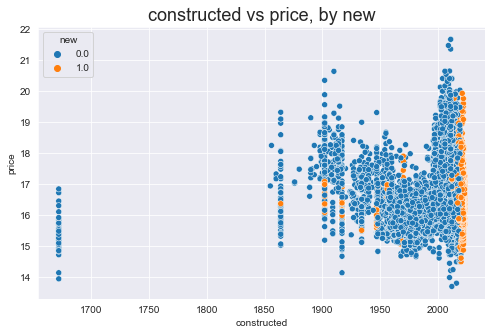

In [43]:
visualizer.plot_vs(featured, "constructed", "price", reg=True, figsize=(8,5), hue="new")

This does show something interesting - outliers exist. There are actually multiple apartments constructed before 2000 which as considered new. This is of course wrong. We will alter the *new* feature to be true when the apartment was buildt after 2018, else false. Lets see what this does.

                  new  constructed     price
new          1.000000     0.513370 -0.124977
constructed  0.513370     1.000000  0.103806
price       -0.124977     0.103806  1.000000


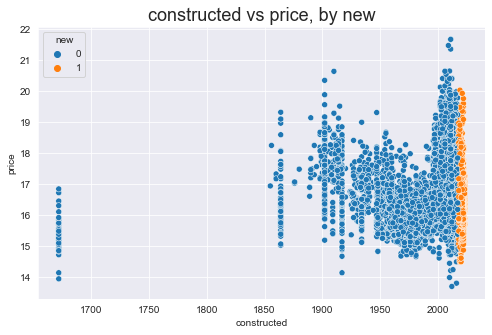

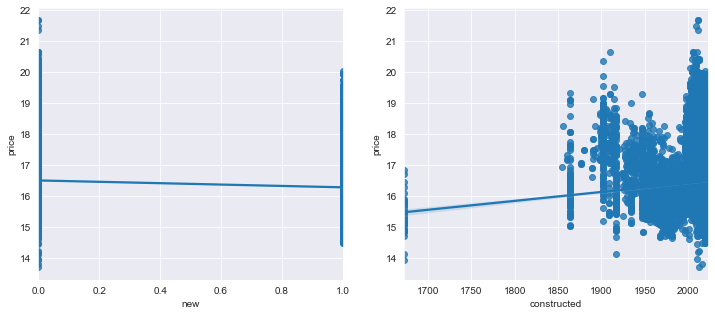

In [84]:
featured = preprocessor.redo_new(featured.copy())
visualizer.plot_vs(featured, "constructed", "price", reg=True, figsize=(8,5), hue="new")
visualizer.corr_target(featured, cols=["new", "constructed",], target='price')

This gives a sizable improvement to the *new* feature, but it is of course dependent on the construction year. As we discussed earlier in the exploration phase, the construction year did now really have the impact one might think on the price. When altering the *new* feature based on the actual construction year, we have "merged" these features together. Therefore - we will drop the *constructed* feature, and keep the *new* feature.

Lets once again look at the correlation grid. We will now look further into how can use the new and old features to improve the dataset.

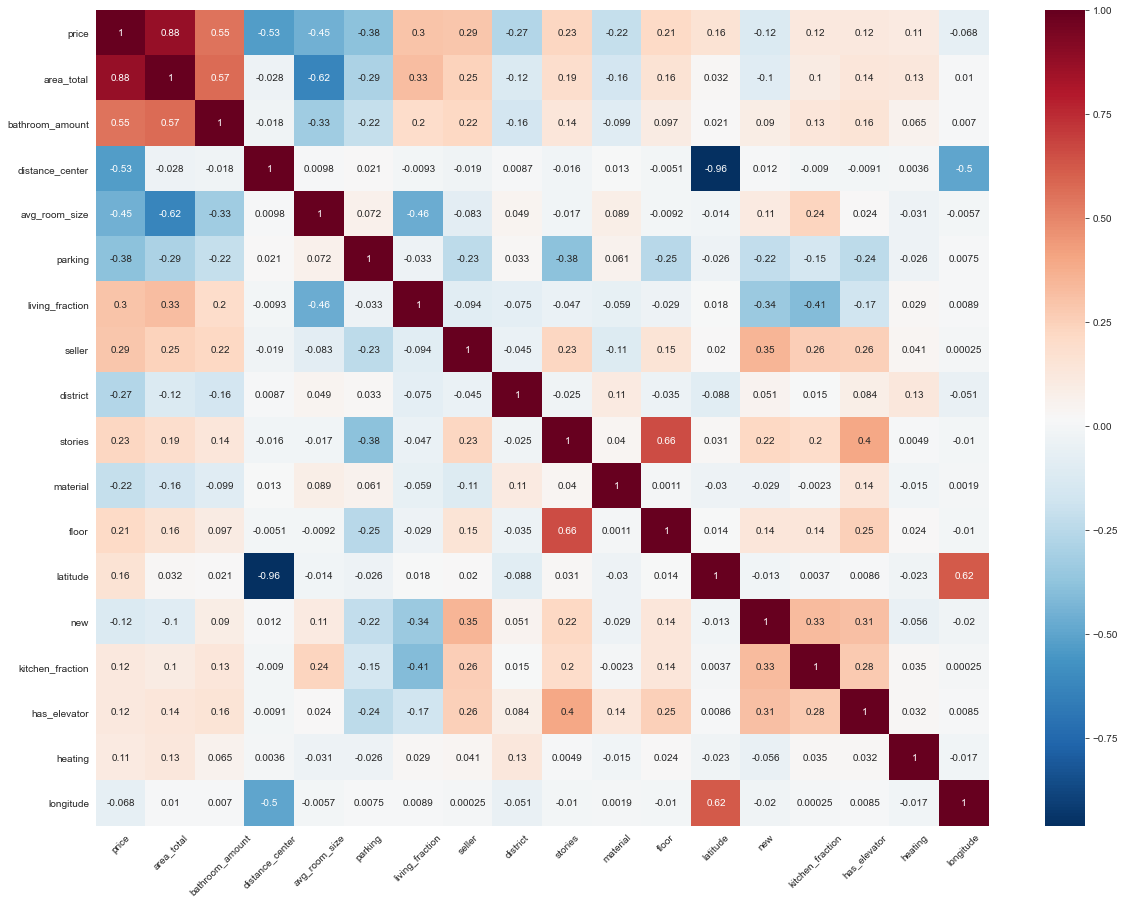

In [85]:
featured = preprocessor.remove_labels(featured.copy(), ["constructed"])
visualizer.price_correlation(featured)

Lets make a strategy.
We see that *heating* is a feature not really correlating to anything. Therefore, we will remove it.<br>
We see that *floor* and *stories* has a very high correlation. We should try to find something to do about this.<br>
We see that the *latitude* is much more impactful than the *longitude* when it comes to both *price* and *distance_center*. We will look into how we either remove *latitude* and/or *longitude*, or if we need to do something else with them.

In [86]:
#featured = preprocessor.remove_labels(featured.copy(), ["heating"])
print("Number of features so far:", featured.shape[1])
featured.head()

Number of features so far: 18


,seller,price,area_total,floor,new,latitude,longitude,district,material,stories,parking,heating,avg_room_size,living_fraction,kitchen_fraction,bathroom_amount,distance_center,has_elevator
0,3.0,15.781156,4.097672,2.0,1,55.544046,37.478055,11.0,3.0,9.0,1.0,0.0,2.048836,0.845782,0.635163,2.0,25022.080164,2
1,3.0,16.166886,4.488636,18.0,0,55.861282,37.666647,2.0,3.0,25.0,1.0,0.0,1.496212,0.867038,0.606263,2.0,12267.029455,2
2,3.0,16.014916,4.375757,12.0,1,55.663299,37.515335,6.0,3.0,15.0,1.0,0.0,1.458586,0.853086,0.721475,2.0,12060.133853,2
3,3.0,16.166886,4.488636,18.0,0,55.861282,37.666647,2.0,3.0,25.0,1.0,0.0,1.496212,0.867038,0.603312,2.0,12267.029455,2
4,3.0,16.447399,4.369448,7.0,0,55.590785,37.451438,11.0,2.0,15.0,1.0,0.0,2.184724,0.820131,0.661496,1.0,21041.782467,2


In [112]:
categorical = preprocessor.split_categorical_features(featured.copy(), ["seller", "district", "material", "has_elevator", "heating"])

## TESTING MODEL FOR 11. Nov

The randomf model in TestModel

In [118]:
# Seperating training and test data
train_data = categorical[:23285].copy()
labels = train_data["price"]
test_data = categorical[23285:].copy()
test_data.drop("price", 1, inplace=True)
print("Split data into train and test")

# Splitting training data into training and validation, removed the price for each of them afterwards
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, stratify=np.log(train_data.price).round(), test_size=0.25)
x_train.drop("price", 1, inplace=True)
x_test.drop("price", 1, inplace=True)
print("Validation data created and price dropped")
print("The number of features are now:", x_train.shape[1])

print("Fitting model...")
model = TestModel(x_train, y_train)
pipeline = model.fit()
test_pred = np.round([np.expm1(pred) for pred in model.predict(x_test)])
test_labels = np.round([np.expm1(lab)for lab in y_test])
print("Fitting complete")

res = pd.DataFrame([(test_labels[i], test_pred[i]) for i in range(len(test_pred))], columns=["actual", "prediction"])
print("RMLSE: %s" % model.root_mean_squared_log_error(test_labels, test_pred))
res.to_csv("./split.csv", index=False)

pred = [np.expm1(p) for p in model.predict(test_data)]
model.save_predictions(pred)


Split data into train and test
Validation data created and price dropped
The number of features are now: 38
Fitting model...
Fitting complete
RMLSE: 0.15949980967359803


,id,price_prediction
0,23285,2.713856e+07
1,23286,9.279345e+06
2,23287,6.107942e+06
3,23288,1.057873e+07
4,23289,6.228151e+06
...,...,...
9932,33217,2.410436e+07
9933,33218,1.989369e+07
9934,33219,9.774344e+06
9935,33220,1.026273e+07
